In [1]:
import sys
import pymc3 as pm, theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


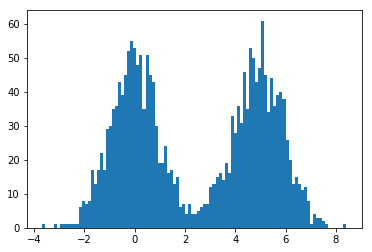

In [2]:
# observed data
y = np.concatenate([np.random.normal(loc=0, scale=1, size=1000),
                    np.random.normal(loc=5, scale=1, size=1000)])
# show data
plt.hist(y, bins=100)

In [17]:
with pm.Model() as model:
    # model description
    mix_nbr = 6
    sd = pm.HalfNormal('sd', sd=np.asarray([1.0] * mix_nbr), shape=mix_nbr)
    mu = pm.HalfNormal('mu', sd=np.asarray([5.0] * mix_nbr), shape=mix_nbr)
    components = pm.Normal.dist(mu=mu, sd=sd, shape=mix_nbr)
    w = pm.Dirichlet('w', a=np.array([1.0] * mix_nbr))
    mix = pm.Mixture('mix', w=w, comp_dists=components, observed=y)
    re_mix = pm.Mixture('re_mix',w=w,comp_dists=components,shape=len(y))

    # optimization
    mean_field = pm.fit(n=10000, 
                        obj_optimizer=pm.adagrad(learning_rate=0.1))
    trace = mean_field.sample(1000)

Average Loss = 4,569.9: 100%|██████████| 10000/10000 [00:28<00:00, 348.92it/s]
Finished [100%]: Average Loss = 4,569.9


In [25]:
pm.fit?

In [24]:
mean_field.params[0].eval().shape

(2017,)

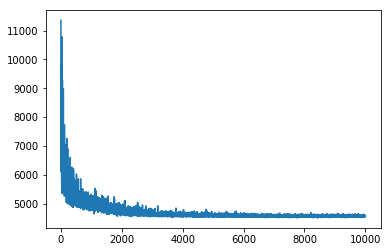

In [18]:
plt.plot(mean_field.hist);

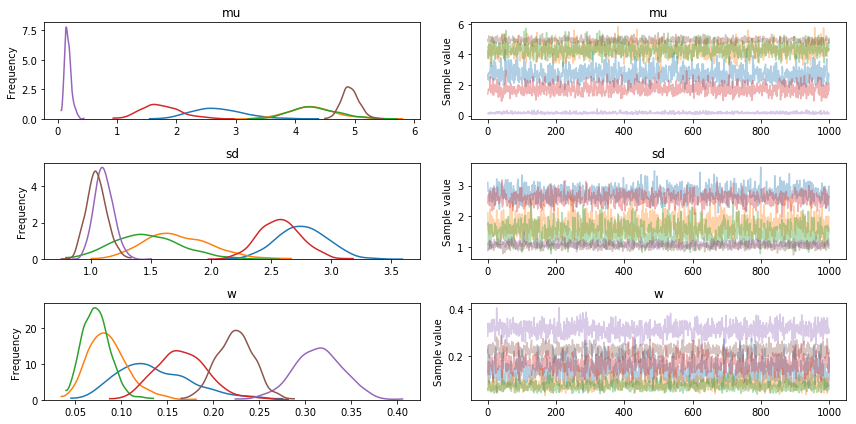

In [19]:
# plot trace
pm.traceplot(trace, varnames=['mu', 'sd', 'w']);

100%|██████████| 2000/2000 [00:03<00:00, 502.25it/s]


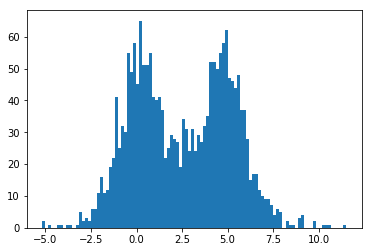

In [20]:
# plot Preditive Posterior Check
with model:
    ppc = pm.sample_ppc(trace, vars=[mix], samples=len(y))
plt.hist(ppc['mix'], bins=100);

In [21]:
y.mean() # original data mean

2.459118406876078

In [22]:
ppc['mix'].mean() # re-sampled mean

2.5360988676284233

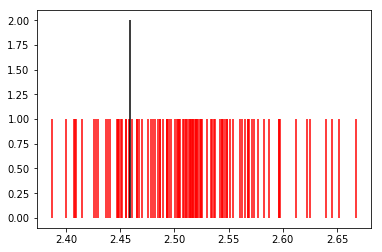

In [14]:
postmean = []
with model:
    for i in range(100):
        ppc = pm.sample_ppc(trace, vars=[mix], samples=len(y), progressbar=False)
        postmean.append(ppc['mix'].mean())
postmean = np.asarray(postmean)

plt.vlines(postmean, 0, 1, 'r')
plt.vlines(y.mean(), 0, 2);

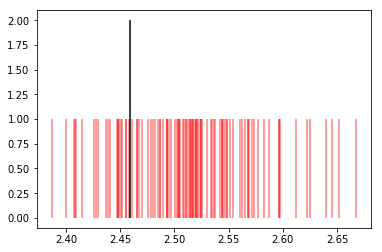

In [16]:
plt.vlines(postmean, 0, 1, 'r', alpha=.5)
plt.vlines(y.mean(), 0, 2);